In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [3]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged:pl.DataFrame
merged = 0
merged = pl.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/reco_geant_nu.pasquet')
# for i,n in enumerate(nu):
#     df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
#     df = df.collect()
#     if i == 0:
#         merged = df
#     else:
#         merged = pl.concat([merged,df])

In [4]:
merged = merged.filter(pl.col('has_valid_pfp')==1).filter(pl.col('pfp_parentID')==-1)

merged = merged.with_columns(
    dist_to_vtx = (
        (pl.col('trkstartx_pandoraTrack')- pl.col('nuvtxx_truth'))**2 + 
        (pl.col('trkstarty_pandoraTrack')- pl.col('nuvtxy_truth'))**2 + 
        (pl.col('trkstartz_pandoraTrack')- pl.col('nuvtxz_truth'))**2
    ).sqrt(),
    dist_vtx = (
        (pl.col('nuvtxx')- pl.col('nuvtxx_truth'))**2 + 
        (pl.col('nuvtxy')- pl.col('nuvtxy_truth'))**2 + 
        (pl.col('nuvtxz')- pl.col('nuvtxz_truth'))**2
    ).sqrt(),
    dist_g_start = (
        (pl.col('trkstartx_pandoraTrack')- pl.col('StartPointx_drifted_geant'))**2 + 
        (pl.col('trkstarty_pandoraTrack')- pl.col('StartPointy_drifted_geant'))**2 + 
        (pl.col('trkstartz_pandoraTrack')- pl.col('StartPointz_drifted_geant'))**2
    ).sqrt(),
    dist_g_end = (
        (pl.col('trkendx_pandoraTrack')- pl.col('EndPointx_drifted_geant'))**2 + 
        (pl.col('trkendy_pandoraTrack')- pl.col('EndPointy_drifted_geant'))**2 + 
        (pl.col('trkendz_pandoraTrack')- pl.col('EndPointz_drifted_geant'))**2
    ).sqrt(),
    line_reco = (
        (pl.col('trkstartx_pandoraTrack')- pl.col('trkendx_pandoraTrack'))**2 + 
        (pl.col('trkstarty_pandoraTrack')- pl.col('trkendy_pandoraTrack'))**2 + 
        (pl.col('trkstartz_pandoraTrack')- pl.col('trkendz_pandoraTrack'))**2
    ).sqrt(),
    line_g = (
        (pl.col('StartPointx_drifted_geant')- pl.col('EndPointx_drifted_geant'))**2 + 
        (pl.col('StartPointy_drifted_geant')- pl.col('EndPointy_drifted_geant'))**2 + 
        (pl.col('StartPointz_drifted_geant')- pl.col('EndPointz_drifted_geant'))**2
    ).sqrt(),
).with_columns(
    angle_lines = (
        (
            (
                (pl.col('trkendx_pandoraTrack')- pl.col('trkstartx_pandoraTrack'))*(pl.col('EndPointx_drifted_geant')- pl.col('StartPointx_drifted_geant')) + 
                (pl.col('trkendy_pandoraTrack')- pl.col('trkstarty_pandoraTrack'))*(pl.col('EndPointy_drifted_geant')- pl.col('StartPointy_drifted_geant')) + 
                (pl.col('trkendz_pandoraTrack')- pl.col('trkstartz_pandoraTrack'))*(pl.col('EndPointz_drifted_geant')- pl.col('StartPointz_drifted_geant'))
            )/(pl.col('line_reco')*pl.col('line_g'))
        ).arccos())*180/np.pi

).filter(
    (pl.col('Mother_geant')==0)
).filter(
    (pl.col('dist_g_start') < 4) & (pl.col('dist_g_end')<4)
# ).filter(
#     (pl.col('dist_g_start') > 200) & (pl.col('dist_g_end')< pl.col('dist_g_start')+20) & (pl.col('dist_g_end')> pl.col('dist_g_start')-20)
).filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
)

In [5]:
def create_division(df:pl.DataFrame, particle, axes = ['x','y','z']):

    list_ndf = [f'trkpidndf_pandoraTrack_{ax}' for ax in axes]

    for ax in axes:
        name_of_div_col = f'chi_{particle}_{ax}'
        df = df.select(
            pl.all(),
            (pl.col(f'trkpidchi{particle}_pandoraTrack_{ax}')).alias(name_of_div_col)
        ).with_columns(
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') <0 ).then(None).otherwise(pl.col(name_of_div_col)).alias(name_of_div_col),
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') <0 ).then(0).otherwise(1).alias(f'ndf_{ax}'),
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') != pl.max_horizontal(list_ndf)).then(0).otherwise(1).alias(f'{ax}_is_max_ndf'),
        )

    list_sum = [f'chi_{particle}_{ax}' for ax in axes]
    list_div = [f'ndf_{ax}' for ax in axes]

    df = df.with_columns( #first minimum, that works with nan
        (pl.min_horizontal(list_sum)).alias(f'trkpid{particle}_min'),
    ).fill_null(0).with_columns(
        (pl.sum_horizontal(list_sum)/pl.sum_horizontal(list_div)).alias(f'trkpid{particle}_av'),
        (pl.col(f'chi_{particle}_x')*pl.col('x_is_max_ndf') + 
         pl.col(f'chi_{particle}_y')*pl.col('y_is_max_ndf') + 
         pl.col(f'chi_{particle}_z')*pl.col('z_is_max_ndf')
        ).alias(f'trkpid{particle}_max')
       
    )
    return df
def pid_eval(df):
    df = create_division(df,'pr')
    df = create_division(df,'ka')
    df = create_division(df,'pi')
    df = create_division(df,'mu')
    return df

def particle_selection(df:pl.DataFrame, type='av'):
    """
    Make pid selection based on different methods
    type: list(str)
        `av` for average between chi2 x,y,z  \n
        `min` for getting minimum chi2  \n
        `max` for getting chi2 with maximum ndf  \n
    """

    df = df.with_columns(
        min_pid = pl.min_horizontal(f'trkpidpr_{type}',f'trkpidka_{type}', f'trkpidpi_{type}',f'trkpidmu_{type}')
    ).with_columns(
        pid = pl.when(pl.col(f'trkpidpr_{type}')==pl.col('min_pid')).then(2212).otherwise(
        pl.when(pl.col(f'trkpidka_{type}')==pl.col('min_pid')).then(321).otherwise(
        pl.when(pl.col(f'trkpidpi_{type}')==pl.col('min_pid')).then(211).otherwise(
        pl.when(pl.col(f'trkpidmu_{type}')==pl.col('min_pid')).then(13).otherwise(
        0))))
    )

    return df
df = pid_eval(merged.filter(check_fiducial('pandoraTrack')))
# why this consume so much ram? 
# q = tracks_pid.filter( pl.col('pid')==13)

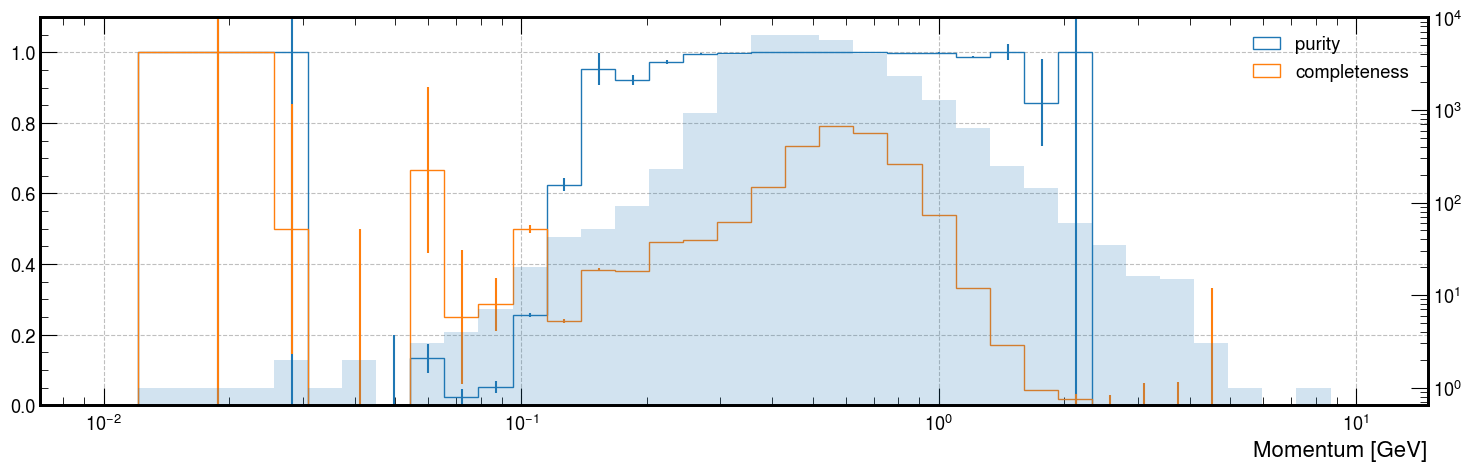

In [6]:
def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

def purity_evolution(
        df:pl.DataFrame,
        Ebins,
        flavour,
        E='P_geant',
        loc='best',
        fig=None,
        plot_purity = True,
        plot_completeness=True,
        plot_events=True,
        label='',
):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    cats:pl.DataFrame
    cats = df.with_columns(
        # Ecut=df.get_column('Eng_geant').cut(Ebins, labels=labels).cast(pl.Int16),
        Ecut_text=pl.col(E).cut(Ebins, include_breaks=True, labels=labels),
        Ecutt=pl.col(E).cut(Ebins).cast(pl.Utf8)
    ).unnest(
        'Ecut_text'
    ).with_columns(
            Ecut = pl.col(E+'_bin').cast(pl.Utf8).cast(pl.Int16),
            brk = pl.col('brk'),
        )
    # print(cats.group_by('Ecut').agg(pl.col('Ecutt').first(), count = pl.col(E).count(), brk=pl.col('brk').first()).sort('Ecut'))
        
    q = (
        cats.group_by('Ecut').agg(
            correct_pdg = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            false_positive = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() != flavour).count().cast(pl.Float64),
            incorrect_pdg = pl.col('pid').filter(pl.col('pid') != flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            total_events = pl.col('pid').filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            Ecutt = pl.col('Ecutt').first(),
            brk = pl.col('brk').first(),

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').with_columns(
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    bins = q.get_column('brk').to_list()
    intervals = q.get_column('Ecutt').to_list()
    start_point = intervals[0]
    end_point = intervals[-1]

    if 'inf' not in start_point: # if inf not in first line, add starting point to bins (breaks only have last part)
        start_point=start_point.replace('(',"*")
        start_point=start_point.replace(',',"*")
        re=float(start_point.split("*")[1])
        bins.insert(0,re)
    else: # if inf in the first line, skip the data (keep bins as starting point is here)
        q = q.tail(-1)

    if 'inf' not in end_point:
        # do nothing, everything set
        pass
    else: #discard last data and bin (inf is the break point)
        q = q.head(-1) 
        bins = bins[:-1]


    bins = np.array(bins)
    bins_center = (bins[1:] + bins[:-1])/2
    bins_width = np.diff(bins)
    # q = fill_empty_categories(q, labels)
    if fig is None:
        fig = plt.figure(figsize=(15,5))

    ax:plt.Axes
    ax = plt.gca()
    point_purity = q.get_column('purity')
    point_completeness = q.get_column('completeness')
    if plot_purity: p = ax.hist(bins[:-1], bins, weights=point_purity, label='purity'+label, histtype='step')
    if plot_completeness: c = ax.hist(bins[:-1], bins, weights=point_completeness, label='completeness'+label, histtype='step')

    error_center = bins_center
    err_purity = q.get_column('errpurity')
    err_completeness = q.get_column('errcompleteness')

    if plot_purity: ax.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[2][0].get_facecolor()[:-1])
    if plot_completeness: ax.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[2][0].get_facecolor()[:-1])
    ax.set_xlabel("Momentum [GeV]")
    # ax.xlim(bins_center[0], bins_center[-1])
    ax.set_ylim(0,1.1)
    ax.legend(loc=loc)
    ax.set_xscale('log')
    if plot_events:
        ax2 = ax.twinx()

        ax2.bar(bins[:-1], q.get_column('total_events'), width=bins_width, align="edge", alpha=0.2, log=True)
        ax2.grid(False)

    plt.sca(ax)        
    return q, bins

Ebins = np.logspace(-2,2, 50)
# Ebins = np.linspace(10.,20,10)


pdg = 2212
# tracks_pid = particle_selection(df, type='av')
# purity_evolution(tracks_pid, Ebins, pdg);

test_min = particle_selection(df, 'min')
purity_evolution(test_min, Ebins, pdg);

# test_max = particle_selection(df, 'max')
# purity_evolution(test_min, Ebins, pdg)

Text(0, 1, '# of events')

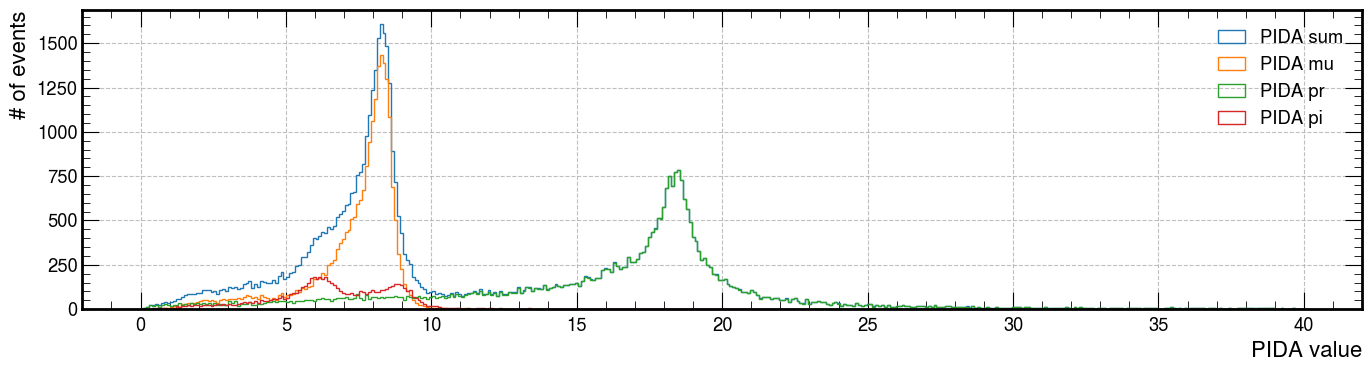

In [7]:
df_pida = merged.filter(
    #     pl.col('Mother_geant') == 0
    # ).filter(
    check_fiducial('pandoraTrack', 20,20,20)
# ).filter(
#     ( pl.col('P_geant') < 1 )# & (pl.col('P_geant')<3)
).with_columns(
    ndf_x = pl.when(pl.col('trkpidndf_pandoraTrack_x')>0).then(pl.col('trkpidndf_pandoraTrack_x')).otherwise(0),
    ndf_y = pl.when(pl.col('trkpidndf_pandoraTrack_y')>0).then(pl.col('trkpidndf_pandoraTrack_y')).otherwise(0),
    ndf_z = pl.when(pl.col('trkpidndf_pandoraTrack_z')>0).then(pl.col('trkpidndf_pandoraTrack_z')).otherwise(0),
).with_columns(
    pida_x = pl.when(pl.col('trkpidpida_pandoraTrack_x')>0).then(pl.col('trkpidpida_pandoraTrack_x')).otherwise(0),
    pida_y = pl.when(pl.col('trkpidpida_pandoraTrack_y')>0).then(pl.col('trkpidpida_pandoraTrack_y')).otherwise(0),
    pida_z = pl.when(pl.col('trkpidpida_pandoraTrack_z')>0).then(pl.col('trkpidpida_pandoraTrack_z')).otherwise(0),
    pida_nx = pl.when(pl.col('trkpidpida_pandoraTrack_x')>0).then(1).otherwise(0),
    pida_ny = pl.when(pl.col('trkpidpida_pandoraTrack_y')>0).then(1).otherwise(0),
    pida_nz = pl.when(pl.col('trkpidpida_pandoraTrack_z')>0).then(1).otherwise(0),
).with_columns(
    pida_mean = pl.sum_horizontal(pl.col('^pida_.$'))/pl.sum_horizontal(pl.col('^pida_n.$')),
    pida_max = pl.max_horizontal(pl.col('^pida_.$')),
    pida_best = pl.when(pl.col('trkpidbestplane_pandoraTrack')==0).then(pl.col('pida_x')).otherwise(
        pl.when(pl.col('trkpidbestplane_pandoraTrack')==1).then(pl.col('pida_y')).otherwise(
        pl.when(pl.col('trkpidbestplane_pandoraTrack')==2).then(pl.col('pida_z')).otherwise(-5)
        )
    ),
    pida_avg = (pl.col('pida_x')*pl.col('ndf_x') +
                pl.col('pida_y')*pl.col('ndf_y') +
                pl.col('pida_z')*pl.col('ndf_z'))/pl.sum_horizontal(pl.col('^ndf_.*$'))

# ).filter(
#     (pl.col('enu_truth')>1) & (pl.col('enu_truth')<10)
)

bins=np.linspace(0,40,400)
plt.figure(figsize=(14,4))
# plt.hist(df_pida['pida_x'], bins=bins, histtype='step');
# plt.hist(df_pida['pida_y'], bins=bins, histtype='step');
# plt.hist(df_pida['pida_z'], bins=bins, histtype='step');
# plt.hist(df_pida['pida_mean'], bins=bins, histtype='step', label='PID Mean');
# plt.hist(df_pida['pida_max'], bins=bins, histtype='step', label='PID max');
plt.hist(df_pida.filter((pl.col('pdg_geant')==2212) | (pl.col('pdg_geant').abs()==211) | (pl.col('pdg_geant').abs()==13))['pida_avg'], bins=bins, histtype='step', label='PIDA sum' );
# plt.hist(df_pida.filter((pl.col('pdg_geant')==2212) | (pl.col('pdg_geant').abs()==211) | (pl.col('pdg_geant').abs()==13))['pida_best'], bins=bins, histtype='step', label='PIDA best plane' );
plt.hist(df_pida.filter((pl.col('pdg_geant').abs()==13))['pida_avg'], bins=bins, histtype='step', label='PIDA mu' );
plt.hist(df_pida.filter((pl.col('pdg_geant')==2212))['pida_avg'], bins=bins, histtype='step', label='PIDA pr' );
plt.hist(df_pida.filter((pl.col('pdg_geant').abs()==211))['pida_avg'], bins=bins, histtype='step', label='PIDA pi' );
# plt.hist(df_pida['pida_avg'], bins=bins, histtype='step', label='PID Avg');
plt.legend()
plt.xlabel('PIDA value')
plt.ylabel('# of events')
# plt.yscale('log')



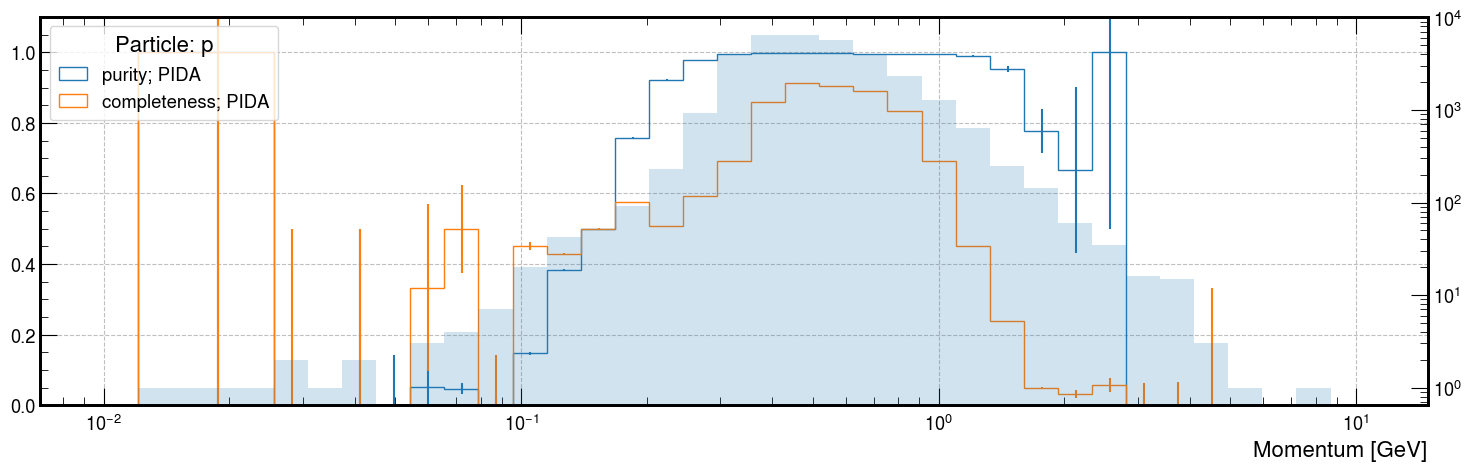

In [12]:
pidatype = 'pida_avg'
df_pida_select = df_pida.with_columns(
    pid = pl.when(pl.col(pidatype)>11).then(2212).otherwise(
        pl.when(pl.col(pidatype)>=7.5).then(13).otherwise(211)
    )
) 

pdg = 2212
purity_evolution(df_pida_select, Ebins, pdg, loc='upper left', label='; PIDA')
# purity_evolution(test_min, Ebins, pdg, loc='upper left', fig=plt.gcf(), plot_events=False, label='; chi2 min');
plt.legend(loc='upper left', frameon=True, title=rf'Particle: {particle.Particle.from_pdgid(pdg).pdg_name}')



In [9]:
df_pida.filter(
    pl.col('P_geant') > 50
).select(
        pl.col('subrun'),
        pl.col('event'),
        pl.col('trkPFParticleID_pandoraTrack'),
        pl.col('pfp_parentID'),
        pl.col('pdg_geant'),
        pl.col('Eng_geant'),
        pl.col('enu_truth'),
        pl.col('^trkstart._.*$'),
        pl.col('^trkend._.*$'),
)

subrun,event,trkPFParticleID_pandoraTrack,pfp_parentID,pdg_geant,Eng_geant,enu_truth,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,trkendd_pandoraTrack
i32,i32,i16,i16,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32


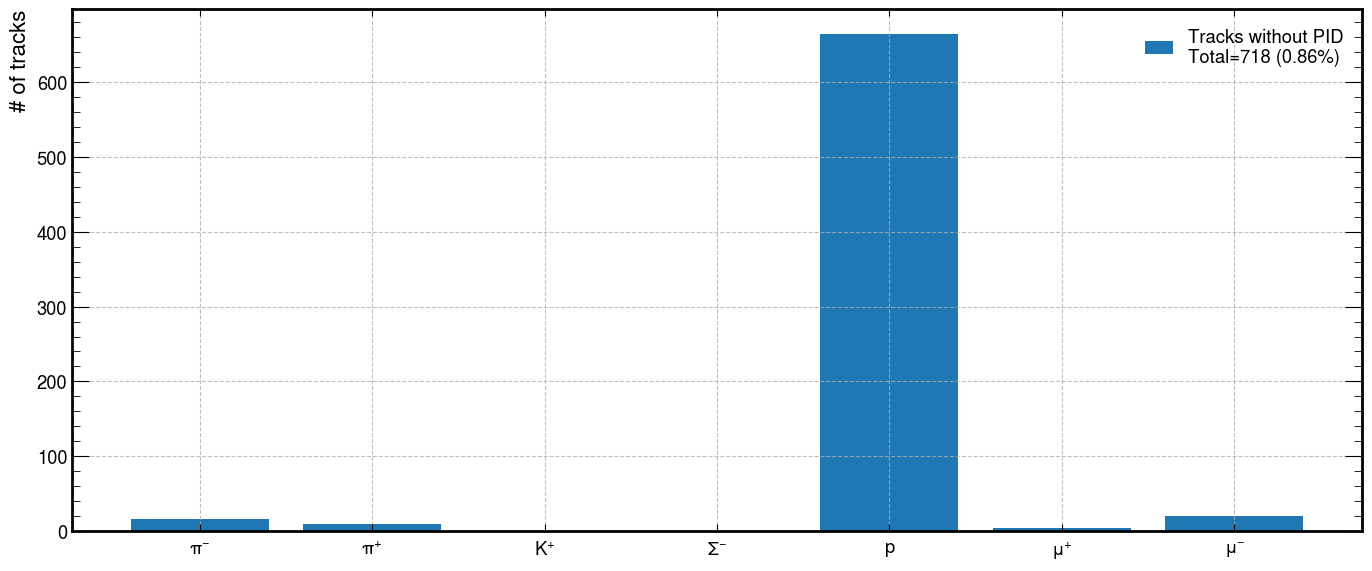

In [10]:
df_no_pid = df.filter(
    (pl.col('trkpidndf_pandoraTrack_x')<0) & (pl.col('trkpidndf_pandoraTrack_y') <0)  & (pl.col('trkpidndf_pandoraTrack_z')<0)
).select(
    pl.col(['subrun','event']),
    pl.col('pdg_geant').map_elements(lambda x: particle.Particle.from_pdgid(x).latex_name)
)

df_no_pid = df_no_pid.group_by('pdg_geant').agg(
    entries = pl.col('pdg_geant').count()
)


pdg_names = [fr'${pdg}$' for pdg in df_no_pid['pdg_geant']]
total = df_no_pid.select(pl.sum('entries')).to_numpy()[0][0]
plt.bar(pdg_names ,df_no_pid['entries'],label=f'Tracks without PID\nTotal={total} ({total*100/len(merged):.2f}%)')
# plt.yscale('log')
plt.tick_params(axis='x',which='minor', bottom=False, top=False)
plt.tick_params(axis='x',which='major', size=5)
plt.ylabel('# of tracks')
plt.legend()

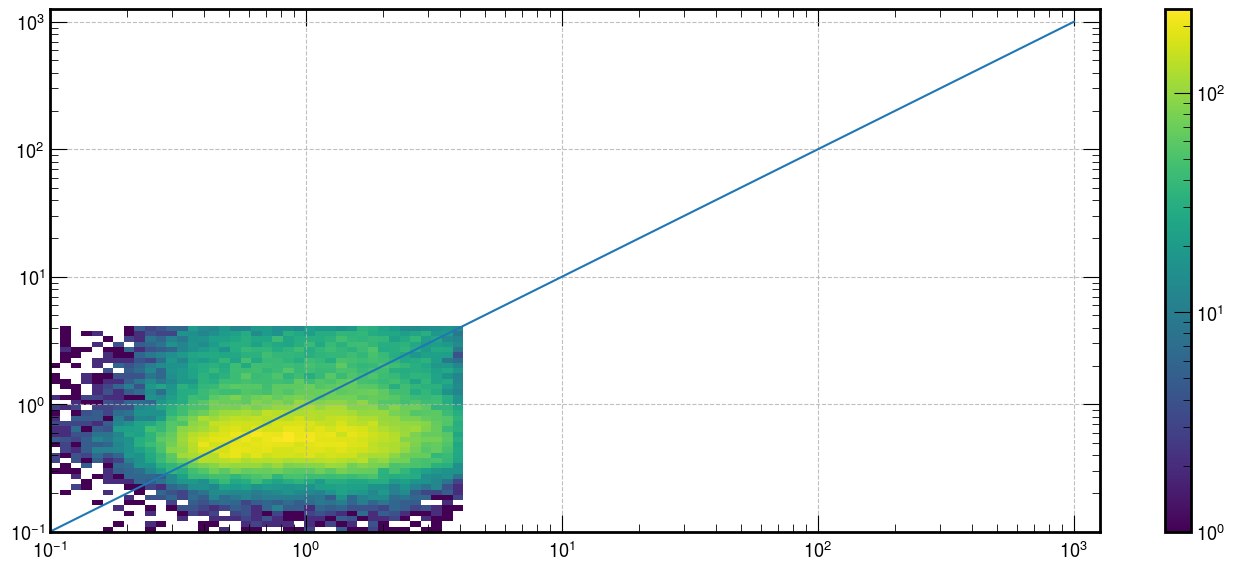

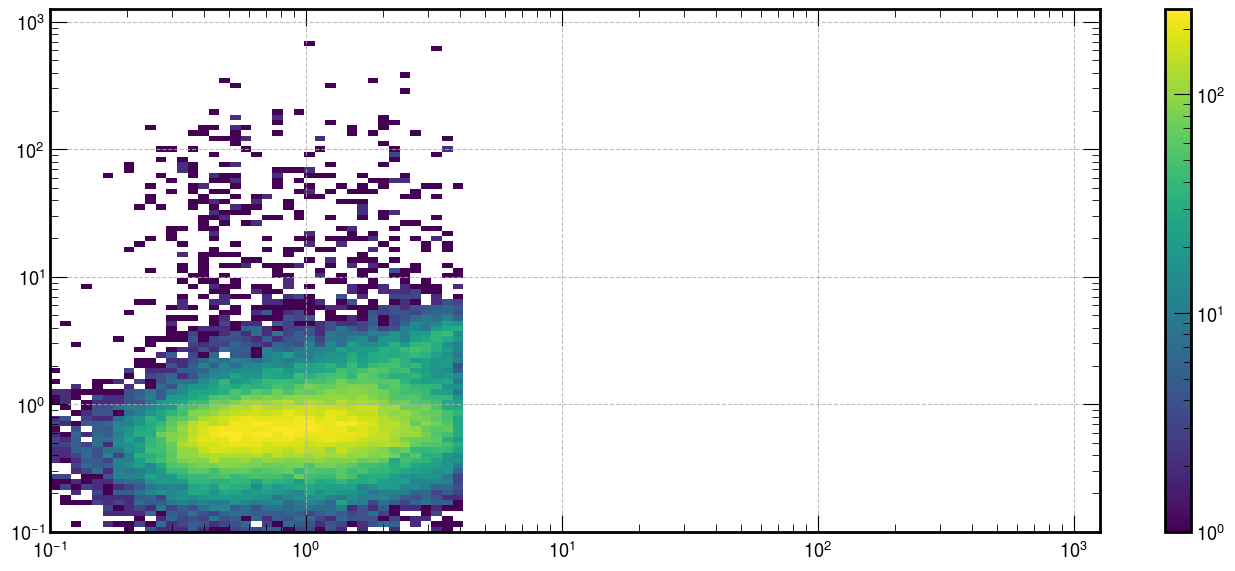

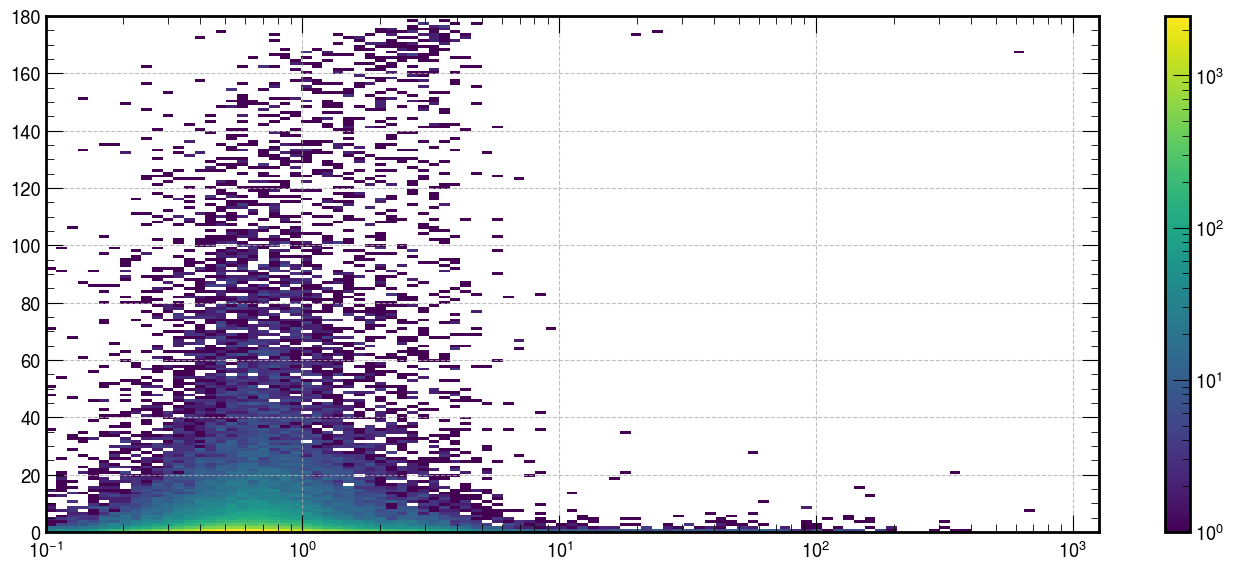

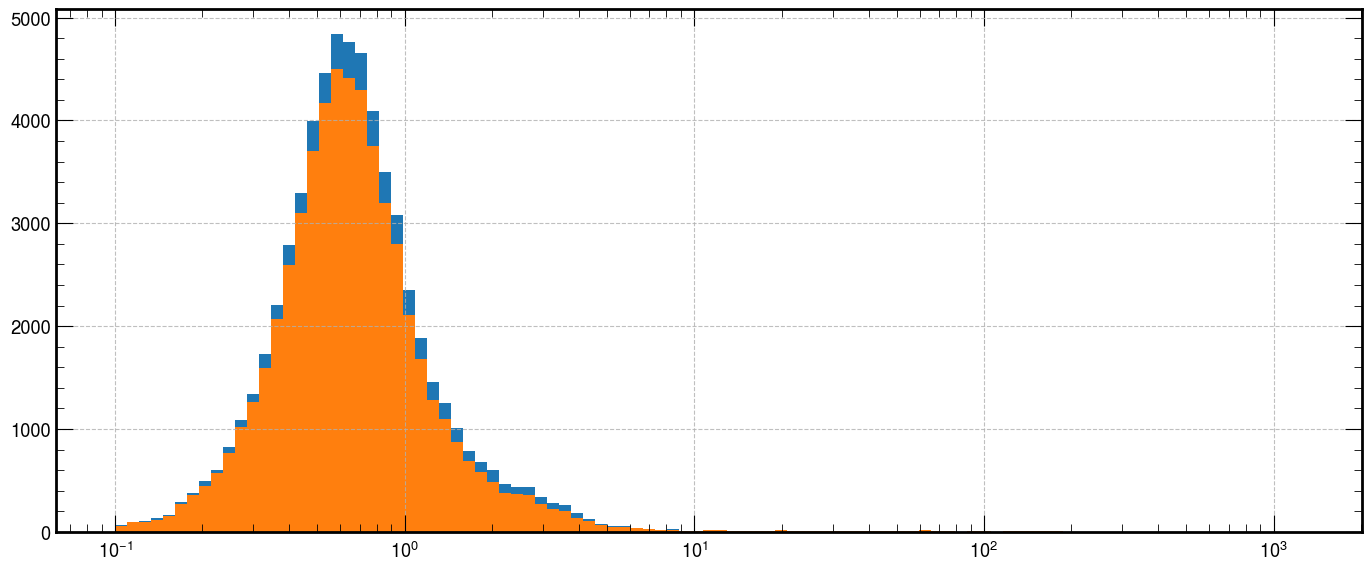

In [11]:
test_reliable = df_pida.with_columns(
    dist_to_vtx = (
        (pl.col('trkstartx_pandoraTrack')- pl.col('nuvtxx_truth'))**2 + 
        (pl.col('trkstarty_pandoraTrack')- pl.col('nuvtxy_truth'))**2 + 
        (pl.col('trkstartz_pandoraTrack')- pl.col('nuvtxz_truth'))**2
    ).sqrt(),
    dist_vtx = (
        (pl.col('nuvtxx')- pl.col('nuvtxx_truth'))**2 + 
        (pl.col('nuvtxy')- pl.col('nuvtxy_truth'))**2 + 
        (pl.col('nuvtxz')- pl.col('nuvtxz_truth'))**2
    ).sqrt(),
    dist_g_start = (
        (pl.col('trkstartx_pandoraTrack')- pl.col('StartPointx_drifted_geant'))**2 + 
        (pl.col('trkstarty_pandoraTrack')- pl.col('StartPointy_drifted_geant'))**2 + 
        (pl.col('trkstartz_pandoraTrack')- pl.col('StartPointz_drifted_geant'))**2
    ).sqrt(),
    dist_g_end = (
        (pl.col('trkendx_pandoraTrack')- pl.col('EndPointx_drifted_geant'))**2 + 
        (pl.col('trkendy_pandoraTrack')- pl.col('EndPointy_drifted_geant'))**2 + 
        (pl.col('trkendz_pandoraTrack')- pl.col('EndPointz_drifted_geant'))**2
    ).sqrt(),
    line_reco = (
        (pl.col('trkstartx_pandoraTrack')- pl.col('trkendx_pandoraTrack'))**2 + 
        (pl.col('trkstarty_pandoraTrack')- pl.col('trkendy_pandoraTrack'))**2 + 
        (pl.col('trkstartz_pandoraTrack')- pl.col('trkendz_pandoraTrack'))**2
    ).sqrt(),
    line_g = (
        (pl.col('StartPointx_drifted_geant')- pl.col('EndPointx_drifted_geant'))**2 + 
        (pl.col('StartPointy_drifted_geant')- pl.col('EndPointy_drifted_geant'))**2 + 
        (pl.col('StartPointz_drifted_geant')- pl.col('EndPointz_drifted_geant'))**2
    ).sqrt(),
).with_columns(
    angle_lines = (
        (
            (
                (pl.col('trkendx_pandoraTrack')- pl.col('trkstartx_pandoraTrack'))*(pl.col('EndPointx_drifted_geant')- pl.col('StartPointx_drifted_geant')) + 
                (pl.col('trkendy_pandoraTrack')- pl.col('trkstarty_pandoraTrack'))*(pl.col('EndPointy_drifted_geant')- pl.col('StartPointy_drifted_geant')) + 
                (pl.col('trkendz_pandoraTrack')- pl.col('trkstartz_pandoraTrack'))*(pl.col('EndPointz_drifted_geant')- pl.col('StartPointz_drifted_geant'))
            )/(pl.col('line_reco')*pl.col('line_g'))
        ).arccos())*180/np.pi

).filter(
    (pl.col('pdg_geant').abs().is_in([13,2212,211])) & (pl.col('Mother_geant')==0)
# ).filter(
#     (pl.col('dist_g_start') > 200) & (pl.col('dist_g_end')< pl.col('dist_g_start')+20) & (pl.col('dist_g_end')> pl.col('dist_g_start')-20)
).filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
)
binsd = np.logspace(-1,3.1,100)
plt.hist2d(test_reliable['dist_g_start'], test_reliable['dist_g_end'], bins=[binsd, binsd], norm='log');
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.plot([0.1,1000],[0.1,1000])

plt.figure()
# plt.hist2d(test_reliable['dist_g_start'], test_reliable['dist_vtx'], bins=[binsd, binsd], norm='log');
plt.hist2d(test_reliable['dist_g_start'], test_reliable['dist_vtx'], bins=[binsd, binsd], norm='log');
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

plt.figure()
binsa=np.linspace(0,180,180)
plt.hist2d(test_reliable['dist_vtx'], test_reliable['angle_lines'], bins=[binsd, binsa], norm='log');
plt.xscale('log')
plt.colorbar()

plt.figure()
plt.hist(test_reliable['dist_vtx'],bins=binsd);
plt.hist(test_reliable.filter(pl.col('angle_lines')<20)['dist_vtx'],bins=binsd);
plt.xscale('log')
# plt.yscale('log')
# test_reliable.sort('dist_vtx').group_by(selection_events()).agg(
#         pl.col('enu_truth').first(),
#         # pl.col('^nuvtx._truth$'),
#         # pl.col('^nuvtx.$'),
#         pl.col('dist_vtx').first(),
#         pl.col('^dist_g.*$').first(),
#         pl.col('trkPFParticleID_pandoraTrack').first(),
#         pl.col('pdg_geant').first(),
#         pl.col('^trkstart._pandoraTrack$').first(),
#         pl.col('^StartPoint._drifted_geant$').first(),
#     ).sort(selection_events()).filter(
#         True
#     # ( pl.col('dist_g_start')>200 ) & ( pl.col('dist_g_start')<400 ) & (pl.col('dist_g_end')>100)
#     )